In [1]:
# NOT WORKING YET - I've just added the call tree (same sequence as old GETM) to get 3D to work - KB
import datetime
import numpy
import pygetm

# Note: "%matplotlib widget" below enables interactive plots but requires https://github.com/matplotlib/ipympl
# Alternatively you could use "%matplotlib notebook" (deprecated).
%matplotlib notebook
import matplotlib.pyplot

<IPython.core.display.Javascript object>


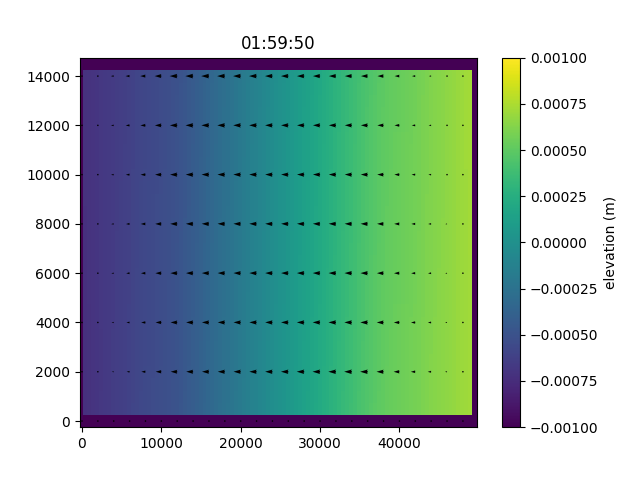

In [2]:
# Set up rectangular domain with outer points masked
domain = pygetm.create_cartesian(500.*numpy.arange(100), 500.*numpy.arange(30), 1)
domain.T.H[1:-1, 1:-1] = 50.
domain.T.mask[1:-1, 1:-1] = 1
domain.initialize()

# Idealized surface forcing
tausx, tausx_ = domain.T.array(fill=0.)
tausx[...] = 0.01
tausy_ = numpy.zeros_like(tausx)
sp, sp_ = domain.T.array(fill=0.)

advection = pygetm.Advection(domain, scheme=1)
momentum = pygetm.Momentum(domain, advection)
sealevel = pygetm.Sealevel(domain)
pressure = pygetm.Pressure(domain)
#KB
temperature = pygetm.Temperature(domain, advection)
salinity = pygetm.Salinity(domain, advection)
density = pygetm.Density(domain)
mixing = pygetm.Mixing(domain)
#KB

# Time
start = datetime.datetime(2020, 1, 1, 0, 0)
stop = datetime.datetime(2020, 1, 1, 2, 0)
timestep = 10.
time = start

# Set up velocity plot
nsample = 4
fig = matplotlib.pyplot.figure()
ax = fig.gca()
pc = ax.pcolormesh(domain.T.xi, domain.T.yi, domain.T.z, vmin=-0.001, vmax=0.001)
cb = fig.colorbar(pc)
cb.set_label('elevation (m)')
Q = ax.quiver(domain.T.x[::nsample, ::nsample], domain.T.y[::nsample, ::nsample], momentum.U[::nsample, ::nsample], momentum.V[::nsample, ::nsample], scale=.3)
title = ax.set_title(time.strftime('%H:%M:%S'))

In [3]:
plotting_interval = 5
istep = 0
while time < stop:
    istep += 1

    momentum.advection_2d(timestep)
    pressure.surface(domain.T.z_, sp_)
    momentum.uv_momentum_2d(timestep, tausx_, tausy_, pressure.dpdx_, pressure.dpdy_)
    sealevel.update(timestep, momentum.U_, momentum.V_)
    domain.depth_update()
    
    #KB
    if runtype > 1 and istep % mode_split == 0:
        domain.start_3d()
        #KB domain.coordinates()
        #KB bottom_friction_3d() - can likely be called from uv_momentum_3d()
        pressure.surface(domain.T.sseo_, sp_)
        momentum.uv_momentum_3d(modes_split,timestep,tausx_, tausy_, pressure.dpdx_, pressure.dpdy_,pressure.dpdx_, pressure.dpdy_, mixing.num_)
        #KB - w_momentum must be checked 
        momentum.w_momentum_3d(dt)
        # SS calculations - from momentum.
        mixing.calculate(momentum.SS_,density.NN_)      

        if runtype > 3:
            temperature%calculate(timestep,momentum.pk,momentum.qk,mixing.nuh_)
            salinity.calculate(timestep,momentum.pk,momentum.qk,mixing.nuh_)
            density.density(salinity.S_,temperature.T_)
            density.buoyancy()
            density.brunt_vaisala()

        # The sequence here must be checked carefully
        momentum.slow_bottom_friction()
        # advection and diffusion for slow 2D velocity terms
        momentum.slow_terms(pressure,idpdx_,idpdy_)
        momentum%Uio=momentum%Ui
        momentum%Ui=0
        momentum%Vio=momentum%Vi
        momentum%Vi=0
    #KB


    # Update velocity plot
    if istep % plotting_interval == 0:
        Q.set_UVC(momentum.U[::nsample, ::nsample], momentum.V[::nsample, ::nsample])
        title.set_text(time.strftime('%H:%M:%S'))
        pc.set_array(domain.T.z.ravel())
        fig.canvas.draw()

    time += datetime.timedelta(seconds=timestep)
    